# Exploring music data

## Data loading

- [Data source](http://millionsongdataset.com/lastfm/)
- Data is a zipped file with JSON files

In [1]:
import zipfile
import json
from urllib import request
from pathlib import Path
from glob import iglob

import pandas as pd
import seaborn as sns

In [2]:
home = Path('~/noteboooks-academy/data').expanduser()
home.mkdir(exist_ok=True, parents=True)

name = "lastfm_test"
url = f"http://millionsongdataset.com/sites/default/files/lastfm/{name}.zip"
path_to_zip = Path(home, f"{name}.zip")
path_to_dir = Path(home, name)

if not path_to_zip.exists():
    print(f'downloading: {path_to_zip}')
    request.urlretrieve(url, filename=path_to_zip)

if not path_to_dir.exists():
    print(f'unzipping: {path_to_zip}')
    with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
        zip_ref.extractall(path=home)

## Parsing JSONs into a data frame

- We parse the JSON files and convert to a data frame
- 104k records

In [3]:
# reading all the JSON files will take a ~2 minutes
# you can set this value to a number to only load a few files
n = None

files_all = iglob(f"{path_to_dir}/**/*.json", recursive=True)

if n is not None:
    files = [next(files_all) for _ in range(n)]
else:
    files = files_all

raw = [json.loads(Path(path).read_text()) for path in files]

In [4]:
df = pd.DataFrame.from_records(raw)

In [5]:
df.head()

,artist,timestamp,similars,tags,track_id,title
0,Jimmy Somerville,2011-08-11 21:15:43.358721,[],[],TRRRRYP128F4284522,Dark Sky (Tony De Vit Mix)
1,Topazz,2011-08-02 21:16:50.250928,"[[TRNJAFY128F92F7E07, 0.0588966], [TRYDEXT128F...","[[house set, 100]]",TRRRRFU12903CBEF39,New Millennium
2,Arab on Radar,2011-08-04 04:39:24.591196,"[[TRJLEPW128F422EC7A, 1], [TRFSJKJ128F422EC7E,...","[[Love, 100], [noise, 100], [going crazy, 100]...",TRRRRQS128F422EC78,His Maintenance
3,New York Art Quartet,2011-08-15 12:26:46.200654,"[[TRERNJG128F4234CBD, 1], [TROQFAY128F422D36F,...","[[freejazz, 100]]",TRRRRUC128F4234CBE,Rosmosis
4,Georgie Fame,2011-08-11 19:07:32.189500,"[[TRCRZGY128F92E31D8, 0.836796], [TRFUOTR128E0...","[[singer-songwriter, 100], [60s, 100]]",TRRRREU128F92E31BA,Vino Tequilla


In [6]:
df.shape

(66046, 6)

## Artists

- The `artist` column has no null values
- There are 7.4k unique values

In [7]:
df.artist.isna().sum().mean()

0.0

In [8]:
df.artist.nunique()

6335

In [9]:
artists = df.groupby('artist').size().sort_values(ascending=False).head(10)

<AxesSubplot:ylabel='artist'>

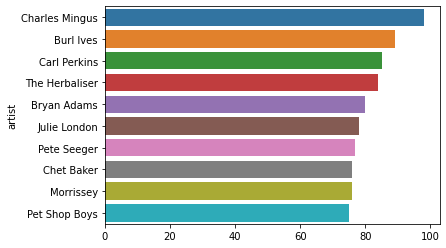

In [10]:
sns.barplot(x=artists, y=artists.index, orient="h")

## Tags

- `tags` contain classifiers for each song
- It's a list of (key, value) tuples. Example: (rock, 100)
- The median is a single tag
- There is an outlier with 100 tags

In [11]:
df.tags.sample(n=10)

3301                                                    []
48491                                                   []
16248                                                   []
41913                                                   []
53593                                                   []
60411                                                   []
26653                                                   []
14673    [[electro, 100], [Electroclash, 42], [electron...
20348                                                   []
35835                                                   []
Name: tags, dtype: object

In [12]:
def tags_len(tags):
    return len(tags)         

df['tags_len'] = df.tags.apply(tags_len)

There's a long tail of tags:

In [13]:
df['tags_len'].describe()

count    66046.000000
mean         8.954395
std         19.311366
min          0.000000
25%          0.000000
50%          1.000000
75%          8.000000
max        100.000000
Name: tags_len, dtype: float64

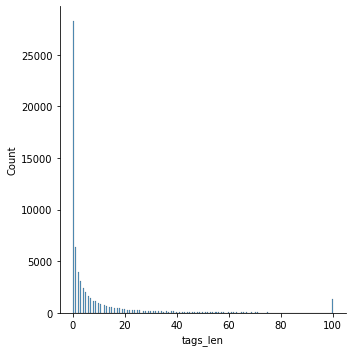

In [14]:
sns.displot(df['tags_len'])

In [15]:
def parse_tags(tags):
    if not tags:
        return {}
    
    # we'll only process the first three     
    to_process = tags[:3]
    
    # convert: [[key0, value0], [key1, value1], ...]
    # into: [key0, key1, ...], [value0, value1, ...], 
    keys, values = zip(*to_process[:3])
    
    # convert to: column_name: key
    keys_mapping = {f'tag_{i}': k for i, k in enumerate(keys)}
    # convert to: column_name: value
    values_mapping = {f'value_{i}': k for i, k in enumerate(values)}
    
    return {**keys_mapping, **values_mapping}

In [16]:
df_tags = pd.DataFrame.from_records(df.tags.apply(parse_tags))
df_tags.head()

,tag_0,value_0,tag_1,tag_2,value_1,value_2
0,NaN,NaN,NaN,NaN,NaN,NaN
1,house set,100,NaN,NaN,NaN,NaN
2,Love,100,noise,going crazy,100,100
3,freejazz,100,NaN,NaN,NaN,NaN
4,singer-songwriter,100,60s,NaN,100,NaN


In [17]:
df_tagged = df.join(df_tags)

## Tracks tagged as "rock"

- 2.5k tracks tagged as rock
- Bryan Adams overly represented with 100 songs
- Followed by Toto, with 33

In [18]:
rock = df_tagged[df_tagged["tag_0"] == "rock"]
rock.head()

,artist,timestamp,similars,tags,track_id,title,tags_len,tag_0,value_0,tag_1,tag_2,value_1,value_2
36,Allister,2011-08-04 12:12:50.779805,"[[TRQRJIA128F930177F, 1], [TRHAXEH128F930177C,...","[[rock, 100], [punk, 100], [pop punk, 100], [P...",TRRRGPA128F9301782,None Of My Friends Are Punks,6,rock,100,punk,pop punk,100,100
71,Boy Kill Boy,2011-08-15 21:05:57.238300,"[[TRAHPVO128F428E87E, 1], [TRCBTBO128F428E87F,...","[[rock, 100], [indie rock, 100], [New British ...",TRRROXI128F428E877,Load + Clear,4,rock,100,indie rock,New British Invasion,100,100
102,Carlos Chaouen,2011-09-07 09:56:17.264780,"[[TRFPEHT128F42A2BB6, 1], [TROOKGO128F42A3DE6,...","[[rock, 100], [Cantautores, 100], [spanish, 50...",TRRRDQN128F42A3DE7,Buenos Aires,4,rock,100,Cantautores,spanish,100,50
126,Bryan Adams,2011-08-05 11:38:32.502695,"[[TRELABG128E0791D47, 1], [TRHMJQQ128E0791D4B,...","[[rock, 100], [pop rock, 40], [soft rock, 26],...",TRRRXIA128E0791D46,Victim Of Love,25,rock,100,pop rock,soft rock,40,26
288,Base Ball Bear,2011-08-13 04:15:17.829654,"[[TRKPZEB128F427BA52, 0.18149], [TRXJFMF128F92...","[[rock, 100], [japanese, 50], [japanese rock, ...",TRRUXQW128F92E4780,Love Mathematics,12,rock,100,japanese,japanese rock,50,50


In [19]:
rock.shape

(1605, 13)

In [20]:
artists_rock = rock.groupby('artist').size().sort_values(ascending=False).head(10)
artists_rock.head()

artist
Bryan Adams          69
Toto                 23
Tom Robinson Band    19
American Hi-Fi       19
Queen                18
dtype: int64

<AxesSubplot:ylabel='artist'>

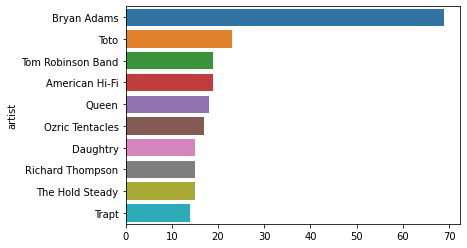

In [21]:
sns.barplot(x=artists_rock, y=artists_rock.index, orient="h")